# Jacobi Iterative Solution of Poisson’s Equation in 1D

> This document try to improve the performance of the algorithm presentend in the paper given by the professor Ramiro, It's a way to get the solution, an iterative solver to compute approximate solutions to a discretization of Poisson’s equation in 1D. The document is intended as a record for our exam and probe of our findigns and results. 
Therefore, we specify all our set of data that were used to plot the speed up graphs 
Team Members : 
***Carlos Andres Arias L, Héctor F. Jiménez S. ***


In this notebook is summarized all the graphs and interpretations 

In [1]:
!pwd && ls  # Where we are in the shell ?

/home/c1b3r/Documents/Developer/HPC/C4rias/Homeworks/Jacobi
data		      jacobi_seq.cc	   jacobi_threads.out  slides
graphs.ipynb	      jacobi_seq.json	   Makefile	       timer.hh
jacobi_parallel.cc    jacobi_seq.out	   paper.pdf
jacobi_parallel.json  jacobi_threads.cc    readme.ipynb
jacobi_parallel.out   jacobi_threads.json  README.md


## Sequential Code CPP

```cpp
#include <iostream>
#include <vector>
#include <fstream>
#include "timer.hh"
using namespace std;
void jacobi(int nsweeps, int n, vector<double> &u, vector<double> &f) {
  double h = 1.0 / n;
  double h2 = h * h;
  vector<double> utmp(n + 1);
  utmp[0] = u[0];
  utmp[n] = u[n];
  //Como debemos correr n iteraciones para ir corrijiendo los valores
  //del procesos de jacobi usamos la funcion discretizada n veces
  for ( int sweep = 0; sweep < nsweeps; sweep += 2 ) {
    for ( int i = 1; i < n; ++i )
      utmp[i] = (u[i - 1] + u[i + 1] + h2 * f[i]) / 2;
    //Actualizamos los valores del vector solución
    for ( int i = 1; i < n; ++i )
      u[i] = (utmp[i - 1] + utmp[i + 1] + h2 * f[i]) / 2;
  }
}

void write_solution(int n, vector<double> &u, const char* fname) {
  double h = 1.0 / n;
  ofstream output;
  output.open (fname);
  for ( int i = 0; i <= n; ++i )
    output << i * h << " " << u[i] << endl;
  output.close();
}

int main (int argc, char** argv) {
  // numero de particiones del vector.
  int n = (argc > 1) ? atoi(argv[1]) : 100;
  // numero de pasos a repetir el algoritmo.
  int nsteps = (argc > 2) ? atoi(argv[2]) : 100;
  //opcional
  char* fname = (argc > 3) ? argv[3] : NULL;
  double h = 1.0 / n;

  vector<double> u(n + 1), f(n + 1);
  // generamos los valores iniciales de Solucion.
  for ( int i = 0; i <= n; ++i )
    f[i] = i * h;
  
  {
    Timer tmt("\"Elapsed time:\"");
    jacobi(nsteps, n, u, f);
    cout << "{" << endl;
    cout << "\"N\": " << n << "," << endl;
    cout << "\"Steps\": " << nsteps << "," << endl;
  }
  cout << "}," << endl;

  if ( fname ) write_solution(n, u, fname);

  return 0;
}
```

## Thread Code 

```cpp
void adjust(vector<double> & u, vector<double> & utmp, vector<double> &f,const int & n, const double & h2) {
  for ( int i = 1; i < n; ++i )
      utmp[i] = (u[i - 1] + u[i + 1] + h2 * f[i]) / 2;
  for ( int i = 1; i < n; ++i )
    u[i] = (utmp[i - 1] + utmp[i + 1] + h2 * f[i]) / 2;
}

void jacobi(int nsweeps, int n, vector<double> &u, vector<double> &f) {
  double h = 1.0 / n;
  double h2 = h * h;
  vector<double> utmp(n + 1);
  utmp[0] = u[0];
  utmp[n] = u[n];

  vector<thread> threads(nsweeps >> 1);

  for ( int sweep = 0; sweep < nsweeps; sweep += 2 ) {
    threads[sweep >> 1] = thread(&adjust, ref(u), ref(utmp), ref(f), ref(n), ref(h2));
  }

  for ( auto &thread : threads ) thread.join();
}
```

## Parallel  Code

The code is still the same as the previous one, you can notice that the only change is in the jacobi iterative solver : 

```cpp
void jacobi(int nsweeps, int n, vector<double> &u, vector<double> &f) {
  double h = 1.0 / n;
  double h2 = h * h;
  vector<double> utmp(n + 1);
  utmp[0] = u[0];
  utmp[n] = u[n];

  for ( int sweep = 0; sweep < nsweeps; sweep += 2 ) {
    #pragma omp parallel for schedule(dynamic)
    for ( int i = 1; i < n; ++i )
      utmp[i] = (u[i - 1] + u[i + 1] + h2 * f[i]) / 2;
    
    #pragma omp parallel for schedule(dynamic)
    for ( int i = 1; i < n; ++i )
      u[i] = (utmp[i - 1] + utmp[i + 1] + h2 * f[i]) / 2;
  }
}
```

## Graphs 

In [2]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
#Path of our data.
paths = ["./data/jacobi_seq.json","data/jacobi_parallel.json","./data/jacobi_threads.json"]

In [3]:
#Load all the json files.
results = []
for path in paths:
    with open(path) as complex_data:
        data_raw = complex_data.read()
        d = json.loads(data_raw)
        results.append(d)

In [4]:
results

[[{'Elapsed time:': 199251, 'N': 100, 'Steps': 100},
  {'Elapsed time:': 1638798, 'N': 100, 'Steps': 1000},
  {'Elapsed time:': 16311488, 'N': 100, 'Steps': 10000},
  {'Elapsed time:': 163868434, 'N': 100, 'Steps': 100000},
  {'Elapsed time:': 1655717, 'N': 1000, 'Steps': 100},
  {'Elapsed time:': 16448979, 'N': 1000, 'Steps': 1000},
  {'Elapsed time:': 164083955, 'N': 1000, 'Steps': 10000},
  {'Elapsed time:': 1648928207, 'N': 1000, 'Steps': 100000},
  {'Elapsed time:': 16914623, 'N': 10000, 'Steps': 100},
  {'Elapsed time:': 184336081, 'N': 10000, 'Steps': 1000},
  {'Elapsed time:': 1658602522, 'N': 10000, 'Steps': 10000},
  {'Elapsed time:': 19508108122, 'N': 10000, 'Steps': 100000},
  {'Elapsed time:': 173263506, 'N': 100000, 'Steps': 100},
  {'Elapsed time:': 1834427157, 'N': 100000, 'Steps': 1000},
  {'Elapsed time:': 17951092528, 'N': 100000, 'Steps': 10000},
  {'Elapsed time:': 177817050389, 'N': 100000, 'Steps': 100000}],
 [{'Elapsed time:': 151606, 'N': 100, 'Steps': 100},
  

### Graphs for Jacobi Sequential

In [5]:
data_seq = results[0]
print(len(data_seq))
data_parallel = results[1]
print(len(data_parallel))
data_threads = results[2]
print(len(data_threads))


16
16
16


In [6]:
steps =[data_seq[i]['Steps'] for i in range(4)] #Steps taken in all the algorithms.
n = steps[:]
graph_seqtime=[]
graph_paralleltime=[]
graph_threadstime=[]
for i in range(0, 16, 4):
    tmp = data_seq[i:i+4]
    aux3 = []
    for i in tmp:
        #print('\n{}'.format(i['Elapsed time:']))
        aux3.append(i['Elapsed time:'])
    graph_seqtime.append(aux3)

In [7]:
for i in range(0, 16, 4):
    tmp = data_parallel[i:i+4]
    aux2 = []
    for i in tmp:
        #print('\n{}'.format(i['Elapsed time:']))
        aux2.append(i['Elapsed time:'])
    graph_paralleltime.append(aux2)

In [8]:
for i in range(0, 16, 4):
    tmp = data_threads[i:i+4]
    aux2 = []
    for i in tmp:
        #print('\n{}'.format(i['Elapsed time:']))
        aux2.append(i['Elapsed time:'])
    graph_threadstime.append(aux2)

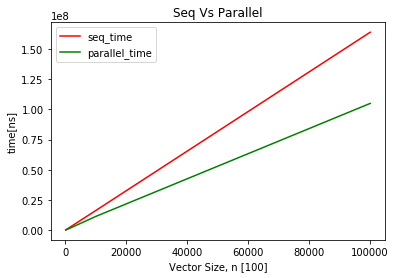

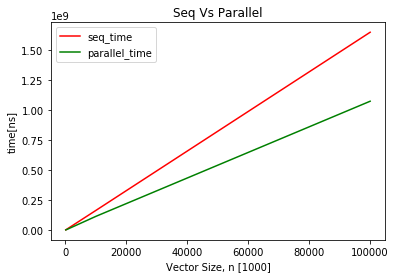

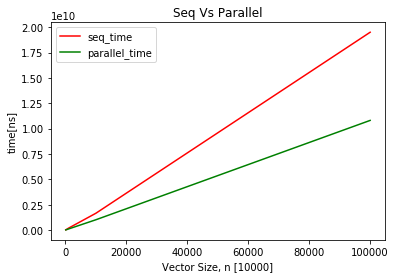

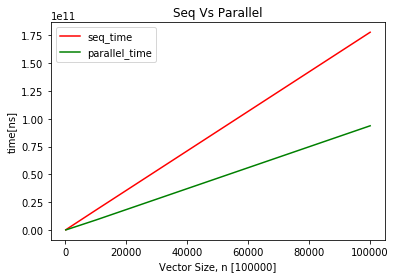

In [18]:
colors =['g','r','b','c']
for i in range(4):
    plt.plot(steps,graph_seqtime[i], 'r',label='seq_time')
    plt.plot(steps,graph_paralleltime[i], 'g',label='parallel_time')
    
    plt.xlabel('Vector Size, n [{}]'.format(steps[i]))
    plt.ylabel('time[ns]')
    plt.legend(loc='upper left')
    plt.title("Seq Vs Parallel")
    plt.show()

In [10]:
speedup = []
for i in range(4):
    aux = []
    for j in range(4):
        aux.append(graph_seqtime[i][j]/graph_paralleltime[i][j])
    speedup.append(aux)

In [11]:
speedup

[[1.3142685645686847,
  1.5693014837903445,
  1.4332508286131607,
  1.5618810420113607],
 [1.4103631709633593,
  1.4909320326644055,
  1.4336637291714425,
  1.535487836627321],
 [1.660541685384787,
  1.7619900480525759,
  1.6354409525770195,
  1.8042577446621362],
 [1.8788183844308424,
  2.078625104804343,
  1.989969774835124,
  1.8974053141012124]]

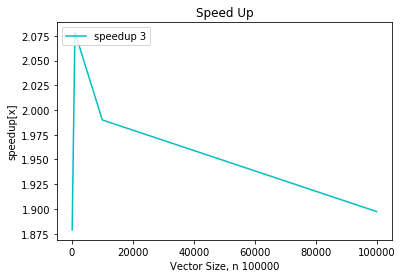

In [12]:
plt.plot(steps,speedup[3], colors[3],label=('speedup {}'.format(3)))
plt.xlabel('Vector Size, n {}'.format(steps[3]))
plt.ylabel('speedup[x]')
plt.legend(loc='upper left')
plt.title("Speed Up")
plt.show()

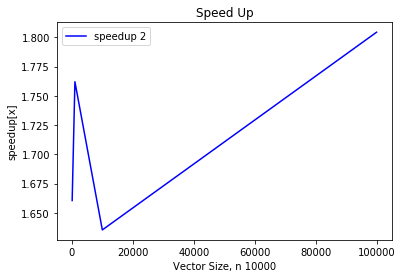

In [13]:
plt.plot(steps,speedup[2], colors[2],label=('speedup {}'.format(2)))
plt.xlabel('Vector Size, n {}'.format(steps[2]))
plt.ylabel('speedup[x]')
plt.legend(loc='upper left')
plt.title("Speed Up")
plt.show()

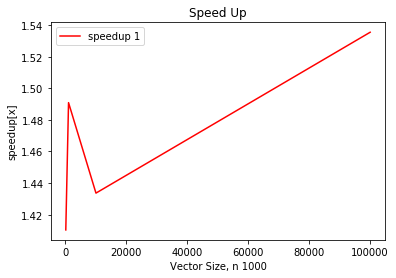

In [14]:
plt.plot(steps,speedup[1], colors[1],label=('speedup {}'.format(1)))
plt.xlabel('Vector Size, n {}'.format(steps[1]))
plt.ylabel('speedup[x]')
plt.legend(loc='upper left')
plt.title("Speed Up")
plt.show()